# **NLP Project**

In this project, it will be used the deep learning model from the paper [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf), by replicating the paper [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071). */Cheers for the authors. Outstanding job!/*

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In this way, we shall create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

I'd like to thank **Mr. Daniel Bourke** for helping with this project.

## Loading Libraries 

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub

import random
import os
import time
import help_me
import string

## Confirm Access to GPU

In [2]:
# !nvidia-smi -L

## Get Data

Getting the data from the [Github repository](https://github.com/Franck-Dernoncourt/pubmed-rct.git).

In [3]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
for dirpath, dirnames, filenames in os.walk('pubmed-rct/'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

There are 5 directories and 1 files in 'pubmed-rct/'.
There are 5 directories and 5 files in 'pubmed-rct/.git'.
There are 0 directories and 13 files in 'pubmed-rct/.git\hooks'.
There are 0 directories and 1 files in 'pubmed-rct/.git\info'.
There are 1 directories and 1 files in 'pubmed-rct/.git\logs'.
There are 2 directories and 0 files in 'pubmed-rct/.git\logs\refs'.
There are 0 directories and 1 files in 'pubmed-rct/.git\logs\refs\heads'.
There are 1 directories and 0 files in 'pubmed-rct/.git\logs\refs\remotes'.
There are 0 directories and 1 files in 'pubmed-rct/.git\logs\refs\remotes\origin'.
There are 2 directories and 0 files in 'pubmed-rct/.git\objects'.
There are 0 directories and 0 files in 'pubmed-rct/.git\objects\info'.
There are 0 directories and 2 files in 'pubmed-rct/.git\objects\pack'.
There are 3 directories and 0 files in 'pubmed-rct/.git\refs'.
There are 0 directories and 1 files in 'pubmed-rct/.git\refs\heads'.
There are 1 directories and 0 files in 'pubmed-rct/.git\

In [4]:
# Checking the files in the PubMed_20K dataset
for _, _, filename in os.walk('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'):
    print(f"Files: {filename}")

Files: ['dev.txt', 'test.txt', 'train.txt']


In [5]:
# Starting the experiments using the 20k dataset with numbers replaced by '@ sign
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [6]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess Data

Writing a function to read in all of the lines of a target text file.

In [7]:
# Create a funtion to read the lines of the document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the lines of the text as a list.
    
    Args:
        filename: a string containing the target filepath
        
    Returns:
        A list of strings with one string per line from the target filename.
    """
    with open(filename, 'r') as f:
        return f.readlines()    

In [8]:
# Reading the training lines
train_lines = get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

> Writing a function which turns each of our datasets into a dictionary format.

In [9]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.
    
    Takes in filename, reads its contents and sorts through each line, extracting
    things like the target label, the text of the sentence, how many sentences are
    in the current abstract and what sentence number the target line is.
    """
    
    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = '' # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts
    
    # loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'): # check to see if the line is and ID line
            abstract_id = line
            abstract_lines = '' # reset the abstract string if the line is an ID line
            
        elif line.isspace(): # check to see if line is a new line or empty space
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
            
            # iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create and empty dictionary for each line
                target_text_split = abstract_line.split('\t') #split target label from text
                line_data['target'] = target_text_split[0] #get target label
                line_data['text'] = target_text_split[1].lower() # get target text and lower it
                line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract
                line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract (start from 0)
                abstract_samples.append(line_data) # add line data to abstract samples list
                
        # if the above conditions are not fulfilled, the line contains a labelled sentence
        else:
            abstract_lines += line
    
    return abstract_samples

In [10]:
%%time 

# get data from file and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt') # dev is another name for val
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
Wall time: 564 ms


In [11]:
# check the first abstract of the training data
train_samples[:3]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11}]

Data in Dictionary format. Let's turn it into DataFrame

In [12]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

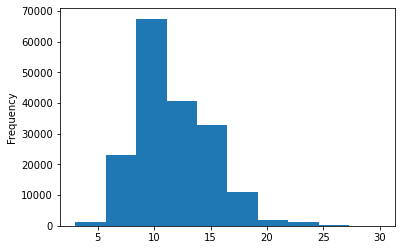

In [14]:
# Length of differente lines
train_df.total_lines.plot.hist()

### Get a list of sentences

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# First 8 training sentences
train_sentences[:8]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Labelling Target 

In [17]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False) # tensorflow is incompatible with sparse matrix datatype
train_labels_ohe = ohe.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_ohe = ohe.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_ohe = ohe.transform(test_df['target'].to_numpy().reshape(-1,1))

# checking training labels
train_labels_ohe

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encode

In [18]:
# Extract labels ('target') and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_enc = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_enc = label_encoder.transform(val_df['target'].to_numpy())
test_labels_enc = label_encoder.transform(test_df['target'].to_numpy())

# checking training labels
train_labels_enc

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Getting class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a Series of Model Experiments

Trying a few different models and watching their behaviour.

> Tip: [Chris Albon](https://chrisalbon.com/)

## Model 0: Getting a baseline 

In [20]:
# TF-IDF multinomial Naive Bayes model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Creating a pipeline
## usually multinomialnb accepts label encoding
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_enc)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences, y=val_labels_enc)

0.7218323844829869

In [22]:
# Making Predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
# Getting baseline results
baseline_results = help_me.calculate_results(val_labels_enc, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing the data (text) for deep sequence models

`vectorization` and `embedding_layers`

In [24]:
# measuring sentence length
sent_len = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_len)
avg_sent_len # average sentenc length

26.338269273494777

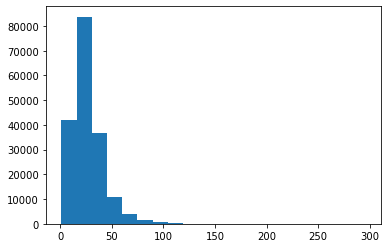

In [25]:
# Evualitng distribution of sentences' lengths
plt.hist(sent_len, bins=20);

In [26]:
# where do the 95% of the lengths reaches?
output_seq_len = int(np.percentile(sent_len, 95))

# max sentence
max_sent = max(sent_len)
print(f'95% of the sentences has until {output_seq_len} tokens - Max length: {max_sent}')

95% of the sentences has until 55 tokens - Max length: 296


### Text Vectorizer Layer

In [27]:
# according to the paper, there are ~68k tokens
max_tokens = 68000

# Creating vectorizer
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens, output_sequence_length=55)

# adapting text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [28]:
# test out text vectorizer
rand_sentence = random.choice(train_sentences)
print(f'Text:\n{rand_sentence}')
print(f'\nLength of the Text: {len(rand_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([rand_sentence])}')

Text:
the appearance of each half of the scar was assessed at @ week , @ weeks , and @ months by the principal investigator .

Length of the Text: 25

Vectorized text: [[   2 3063    4  122 1398    4    2 1912   10  113   15   89   53    3
    41   22    2 3528 3176    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [29]:
# checking more informations on training data
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocabulary: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocabulary: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}')

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [30]:
# general configurations of the vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Creating Text Embedding

In [31]:
# creating token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), output_dim=128,
                              mask_zero=True, name='token_embedding')

# show example embedding
print(f'Sentence before vectorization:\n{rand_sentence}\n')
vec_sentence = text_vectorizer(rand_sentence)
print(f'Sentence after vectorization (before embedding):\n{vec_sentence}')
embed_sentence = token_embed(vec_sentence)
print(f'Sentence after embedding: {embed_sentence}\n')
print(f'Embed sentence shape: {np.expand_dims(embed_sentence,axis=0).shape}')

Sentence before vectorization:
the appearance of each half of the scar was assessed at @ week , @ weeks , and @ months by the principal investigator .

Sentence after vectorization (before embedding):
[   2 3063    4  122 1398    4    2 1912   10  113   15   89   53    3
   41   22    2 3528 3176    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
Sentence after embedding: [[ 0.02303988 -0.03269496  0.0195527  ...  0.02661157 -0.02259035
  -0.01640763]
 [ 0.00204987  0.02991429 -0.02266381 ...  0.01789511 -0.00383307
  -0.0492411 ]
 [-0.00220469  0.00545921 -0.02557361 ... -0.01321427 -0.03368282
  -0.01106764]
 ...
 [ 0.01964394 -0.00804216 -0.00928305 ...  0.04644332 -0.02247282
  -0.01954718]
 [ 0.01964394 -0.00804216 -0.00928305 ...  0.04644332 -0.02247282
  -0.01954718]
 [ 0.01964394 -0.00804216 -0.00928305 ...  0.04644332 -0.02247282
  -0.01954718]]



## Creating Datasets

It's possible to optimize the data loading. One possible method is to turn the data into
`PrefetchDataset`. In this way, we cam prepare the data better. 

Read documentation:
 * [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
 * [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

In [32]:
# turning the data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_ohe))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_ohe))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_ohe))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [33]:
# taking the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(32)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with Token Embeddings

Sequence to be made:
`Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)`

In [34]:
# Create 1D convolutional model to process sequences

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size = 5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1')

# compile the model
model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [35]:
# get summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325 

In [36]:
# fitting the data (for now only in 30% of the original data)
## train and validate on only 30% of the data
history_1 = model_1.fit(train_dataset, steps_per_epoch=int(0.3*len(train_dataset)), epochs=3,
                       validation_data=val_dataset, validation_steps=int(0.3*len(val_dataset)))

Epoch 1/3
1688/1688 [==============================] - 26s 12ms/step - loss: 0.7290 - accuracy: 0.7246 - val_loss: 0.5869 - val_accuracy: 0.7915
Epoch 2/3
1688/1688 [==============================] - 19s 11ms/step - loss: 0.5850 - accuracy: 0.7910 - val_loss: 0.5473 - val_accuracy: 0.8040
Epoch 3/3
1688/1688 [==============================] - 18s 11ms/step - loss: 0.5473 - accuracy: 0.8072 - val_loss: 0.5451 - val_accuracy: 0.8028


In [37]:
# evaluating on the whole validation dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5452 - accuracy: 0.8055


[0.5452253818511963, 0.8055408596992493]

In [38]:
# making predictions (the model outputs probabilities for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

array([[6.86134219e-01, 1.13256037e-01, 5.19569106e-02, 1.09810457e-01,
        3.88423540e-02],
       [6.31314397e-01, 2.17948362e-01, 1.16928965e-02, 1.25392228e-01,
        1.36521477e-02],
       [3.84117603e-01, 7.64553761e-03, 3.98825668e-03, 6.04151428e-01,
        9.71276822e-05],
       ...,
       [4.18130548e-06, 1.18373086e-04, 1.93011481e-03, 2.53783924e-06,
        9.97944772e-01],
       [1.25864789e-01, 3.23156774e-01, 1.85972616e-01, 4.92084287e-02,
        3.15797448e-01],
       [1.04042083e-01, 8.52155268e-01, 3.61312740e-02, 2.03188485e-03,
        5.63949998e-03]], dtype=float32)

In [39]:
# converting pred probabilities to classes
model_1_pred = tf.argmax(model_1_pred_probs, axis=1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [40]:
# model_1 results
model_1_results = help_me.calculate_results(y_true=val_labels_enc, y_pred=model_1_pred)
model_1_results

{'accuracy': 80.55408446974712,
 'precision': 0.8102288207357515,
 'recall': 0.8055408446974712,
 'f1': 0.7993683353268938}

## Model 2: Feature Extraction w/ Pretrained Token Embeddings

Using a pretrained Universal Sequence Encoder (USE) to initialize the token embeddings (pretrained embedding).

In [48]:
# download pretrained tensorflow hub USE
tf_hub_emb_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable=False,
                                 name='universal_sentence_encoder')

In [35]:
# testing out the embedding on a random sentence
print(f'Random Sentence:\n {rand_sentence}')
embed_seq = tf_hub_emb_layer([rand_sentence])
print(f'Sentence after embedding: {embed_seq[0][:30]} (truncated output to 30).')
print(f'Length of sentence embedding: {len(embed_seq[0])}')

Random Sentence:
 community-based research centers .
Sentence after embedding: [ 0.04999234  0.02240906  0.00020972 -0.01061607 -0.0626808  -0.08024239
  0.07699092 -0.06257688 -0.07751091 -0.05798236  0.03175253  0.03715825
  0.07512141 -0.08810013  0.0315895  -0.00051465 -0.07209132  0.04926718
 -0.03594328 -0.07392235  0.00494869 -0.0565359  -0.00270954  0.00155925
  0.01222181 -0.0133688  -0.01169132 -0.01577508 -0.01279055  0.0836598 ] (truncated output to 30).
Length of sentence embedding: 512


In [36]:
len(class_names)

5

### Building and Fitting the Model

In [65]:
# for text, labels in train_dataset.take(1):  # only take first element of dataset
#     numpy_text = text.numpy()
#     numpy_labels = labels.numpy()

In [37]:
# Feature extractor model with TF Hub Layer (USE)

inputs = layers.Input(shape=[], dtype=tf.string) # inputs of USE are lists
embedded_layer = tf_hub_emb_layer(inputs)
x = layers.Dense(128, activation='relu')(embedded_layer)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)

# compiling the model
model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) #values are OHE

In [68]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256,872,069
Trainable params: 74,245
Non-trainable params: 256,797,824
__________________________________________

In [69]:
history_2 = model_2.fit(train_dataset, epochs=3, steps_per_epoch=len(train_dataset), validation_data=val_dataset,
                       validation_steps=len(val_dataset))

Epoch 1/3
5627/5627 [==============================] - 100s 17ms/step - loss: 0.6970 - accuracy: 0.7326 - val_loss: 0.6326 - val_accuracy: 0.7572
Epoch 2/3
5627/5627 [==============================] - 94s 17ms/step - loss: 0.6087 - accuracy: 0.7672 - val_loss: 0.6048 - val_accuracy: 0.7690
Epoch 3/3
5627/5627 [==============================] - 94s 17ms/step - loss: 0.5754 - accuracy: 0.7812 - val_loss: 0.6000 - val_accuracy: 0.7706


In [70]:
# evaluate on test dataset
model_2.evaluate(test_dataset)

942/942 [==============================] - 14s 15ms/step - loss: 0.6225 - accuracy: 0.7649


[0.622536301612854, 0.7648581266403198]

In [71]:
# getting probabilities
model_2_pred_probs = model_2.predict(test_dataset)
model_2_pred_probs

array([[2.21065030e-01, 1.40405446e-01, 1.62753463e-01, 1.43608317e-01,
        3.32167745e-01],
       [1.27343088e-01, 8.69997125e-03, 6.06662095e-01, 1.83495745e-01,
        7.37990290e-02],
       [1.84474178e-04, 7.07519997e-04, 9.60877895e-01, 4.07941756e-04,
        3.78222615e-02],
       ...,
       [6.14856663e-06, 6.80315401e-03, 4.95160697e-04, 1.61401556e-06,
        9.92693901e-01],
       [7.35218986e-04, 2.67261565e-02, 2.37505697e-03, 1.07065214e-04,
        9.70056474e-01],
       [1.03722354e-02, 7.79365659e-01, 7.32115731e-02, 1.56648252e-02,
        1.21385790e-01]], dtype=float32)

In [74]:
# converting the predictions to classes
model_2_pred = tf.argmax(model_2_pred_probs, axis=1) # return the index of the highest value | axis = 1 compares columns
model_2_pred

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([4, 2, 2, ..., 4, 4, 1], dtype=int64)>

In [80]:
# getting the result of the metrics with the test dataset
model_2_results = help_me.calculate_results(y_true=test_labels_enc, y_pred=model_2_pred)
model_2_results

{'accuracy': 76.4858138377302,
 'precision': 0.7611258860613508,
 'recall': 0.7648581383773021,
 'f1': 0.7607414389715157}

## Model 3: Conv1D with Character Embedding

### Creating a char-level tokenizer

In [34]:
# building function to help extract character from sentences
def split_sentences(sentences):
    return ' '.join(list(sentences))

# splitting non-character-level sequence into sentences
split_sentences(rand_sentence)

't h e   a p p e a r a n c e   o f   e a c h   h a l f   o f   t h e   s c a r   w a s   a s s e s s e d   a t   @   w e e k   ,   @   w e e k s   ,   a n d   @   m o n t h s   b y   t h e   p r i n c i p a l   i n v e s t i g a t o r   .'

In [35]:
# creating data-level character splittings
train_char = [split_sentences(sentence) for sentence in train_sentences]
val_char = [split_sentences(sentence) for sentence in val_sentences]
test_char = [split_sentences(sentence) for sentence in test_sentences]

train_char[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [36]:
# taking average character length
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

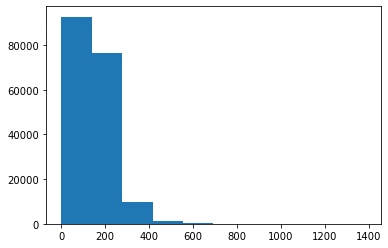

In [37]:
# checking distribuiton of char-level lengths
plt.hist(char_len, bins=10);

In [38]:
# taking the third percentil corresponding to 95% of char lengths
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [39]:
# numbers of tokens for text vectorizer
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [40]:
# char-level token vectorizer instance
NUM_CHARS_TOKEN = len(alphabet) + 2 # OOV terms and ' ' (space)
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHARS_TOKEN, output_sequence_length=output_seq_char_len,
                                          standardize='lower_and_strip_punctuation', name='char_vectorizer')

# adapt char vectorizer to training characters
char_vectorizer.adapt(train_char)

In [41]:
# checking char vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in char_vocab: {len(char_vocab)}')
print(f'5 most common words in char_vocab: {char_vocab[:5]}')
print(f'5 least common words in char_vocab: {char_vocab[-5:]}')

Number of different characters in char_vocab: 28
5 most common words in char_vocab: ['', '[UNK]', 'e', 't', 'i']
5 least common words in char_vocab: ['k', 'x', 'z', 'q', 'j']


In [42]:
# testing char vectorizer
random_chars = random.choice(train_char)
print(f'Char text: \n{random_chars}')
print(f'\nChar text length: \n{len(random_chars.split())}')
print(f'\nVectorizer Chars: \n{char_vectorizer(random_chars)}')
print(f'\nLength of Vectorized Chars: {len(char_vectorizer(random_chars))}')

Char text: 
t h e r e   w e r e   n o   s i g n i f i c a n t   d i f f e r e n c e s   i n   t h e   c l i n i c a l   c h a r a c t e r i s t i c s   b e t w e e n   t h e   g r o u p s   a t   b a s e l i n e   .

Char text length: 
88

Vectorizer Chars: 
[ 3 13  2  8  2 20  2  8  2  6  7  9  4 18  6  4 17  4 11  5  6  3 10  4
 17 17  2  8  2  6 11  2  9  4  6  3 13  2 11 12  4  6  4 11  5 12 11 13
  5  8  5 11  3  2  8  4  9  3  4 11  9 22  2  3 20  2  2  6  3 13  2 18
  8  7 16 14  9  5  3 22  5  9  2 12  4  6  2  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  

### Creating a char-level embedding layer

In [43]:
# creating embedding layer
emb_char_layer = layers.Embedding(input_dim=len(char_vocab), output_dim = 25, mask_zero=False, name='char_embed')

In [44]:
# Testing embedded layer
print(f'Char text:\n{random_chars}\n')
print(f'Embedded chars:\n{emb_char_layer(char_vectorizer([random_chars]))}')
print(f'Character embedding shape: {emb_char_layer(char_vectorizer([random_chars])).shape}')

Char text:
t h e r e   w e r e   n o   s i g n i f i c a n t   d i f f e r e n c e s   i n   t h e   c l i n i c a l   c h a r a c t e r i s t i c s   b e t w e e n   t h e   g r o u p s   a t   b a s e l i n e   .

Embedded chars:
[[[-0.01334344 -0.01115595 -0.04494194 ... -0.03887565  0.04782024
   -0.01241448]
  [-0.00413412  0.01929874  0.03192815 ... -0.03262569 -0.02945203
   -0.0167611 ]
  [-0.01876626  0.04941168  0.0060109  ...  0.0460773   0.0497751
    0.03906249]
  ...
  [ 0.00715106  0.01826962  0.01032513 ...  0.04638679  0.03125017
    0.01806043]
  [ 0.00715106  0.01826962  0.01032513 ...  0.04638679  0.03125017
    0.01806043]
  [ 0.00715106  0.01826962  0.01032513 ...  0.04638679  0.03125017
    0.01806043]]]
Character embedding shape: (1, 290, 25)


In [45]:
# building the model
inputs = layers.Input(shape=(1,), dtype=tf.string)
vectors = char_vectorizer(inputs)
embs = emb_char_layer(vectors)
x = layers.Conv1D(128, kernel_size=9, activation='relu', padding='same')(embs)
x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3')

# compiling the model
model_3.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [49]:
# model summary
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d (Conv1D)             (None, 290, 128)          28928     
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                            

In [46]:
# creating prefetched data in order to optimize data loading
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_char, train_labels_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_char, val_labels_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_char, test_labels_ohe)).batch(32).prefetch(32)

In [51]:
# fitting the model with the data
history_3 = model_3.fit(train_char_dataset, batch_size=32, epochs=5, steps_per_epoch=5627, validation_data=val_char_dataset,
                        validation_steps=945)

Epoch 1/5
5627/5627 [==============================] - 90s 15ms/step - loss: 0.7798 - accuracy: 0.6986 - val_loss: 0.6682 - val_accuracy: 0.7506
Epoch 2/5
5627/5627 [==============================] - 74s 13ms/step - loss: 0.6078 - accuracy: 0.7730 - val_loss: 0.5969 - val_accuracy: 0.7807
Epoch 3/5
5627/5627 [==============================] - 561s 100ms/step - loss: 0.5589 - accuracy: 0.7932 - val_loss: 0.5730 - val_accuracy: 0.7880
Epoch 4/5
5627/5627 [==============================] - 57s 10ms/step - loss: 0.5279 - accuracy: 0.8046 - val_loss: 0.5609 - val_accuracy: 0.7935
Epoch 5/5
5627/5627 [==============================] - 56s 10ms/step - loss: 0.5048 - accuracy: 0.8133 - val_loss: 0.5698 - val_accuracy: 0.7911


In [52]:
# evaluating model
model_3.evaluate(test_char_dataset, verbose=1)

942/942 [==============================] - 5s 6ms/step - loss: 0.5977 - accuracy: 0.7817


[0.5977244973182678, 0.7817487716674805]

In [53]:
# taking model's probabilities
model_3_pred_probs = model_3.predict(test_char_dataset)
model_3_pred_probs

array([[2.6148900e-01, 1.6174294e-01, 5.1166829e-02, 1.7032297e-01,
        3.5527819e-01],
       [1.5462803e-02, 3.5096001e-02, 5.6635416e-01, 1.1218946e-02,
        3.7186813e-01],
       [1.7403161e-05, 6.5749096e-05, 8.8835776e-01, 1.6615511e-05,
        1.1154251e-01],
       ...,
       [4.3190998e-06, 3.5978500e-03, 8.8440618e-03, 7.6254059e-06,
        9.8754615e-01],
       [2.7362604e-04, 3.6118224e-02, 5.6060846e-03, 2.6308489e-04,
        9.5773900e-01],
       [1.6426545e-04, 5.8388483e-02, 9.1813654e-03, 8.4607433e-05,
        9.3218130e-01]], dtype=float32)

In [54]:
# taking model's categories from prediction prababilities
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([4, 2, 2, ..., 4, 4, 4], dtype=int64)>

In [56]:
# calculating model results
model_3_results = help_me.calculate_results(y_true=test_labels_enc, y_pred=model_3_preds)
model_3_results

{'accuracy': 78.17487970798075,
 'precision': 0.7797125174662126,
 'recall': 0.7817487970798075,
 'f1': 0.7780227200595281}

## Model 4: Token Embeddings + Character Embeddings (Hybrid Embedding Layer)

Steps to be made:
1. Create a token-level model
2. Create a character-level model
3. Concatenate both
4. Build a series of output layers on top of the previous one
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [49]:
# 1. token inputs/model
token_input = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_emb_layer(token_input)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_input, token_output, name='token_model')

# 2. char inputs/model
char_input = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vector = char_vectorizer(char_input)
char_embedds = emb_char_layer(char_vector)
char_bid_lstm = layers.Bidirectional(layers.LSTM(25))(char_embedds) # 25x2 
char_model = tf.keras.Model(char_input, char_bid_lstm, name='char_model')

# 3. concatenating token and char inputs (hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_concat')([token_model.output, char_model.output])

# 4. output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_Dense = layers.Dense(256, activation='relu')(combined_dropout)
second_dropout = layers.Dropout(0.3)(combined_Dense)
outputs = layers.Dense(num_classes, activation='softmax')(second_dropout)

# 5. Building the model
model_4 = tf.keras.Model([token_model.input, char_model.input], outputs, name='model_4_token_char_embeddings')

In [50]:
# model_4 summary
model_4.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['tok

In [52]:
# plotting the embedded model
plot_model(model_4)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [53]:
# compiling the model
model_4.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

### Combining token and character data into a tf.data Dataset

Efficient data pipeline

In [59]:
def data_loading_pipeline(X, y, batch_size=32):
    
    """
    Function that creates a dataset in order to improve data loading into the model.
    Args:
        X: Original data
        y: labels
        batch_size: default (32)
        
    returns:
        prefetched dataset
    """
    
    # creating dataset
    data = tf.data.Dataset.from_tensor_slices(X)
    labels = tf.data.Dataset.from_tensor_slices(y)
    dataset = tf.data.Dataset.zip((data, labels))
    
    # prefetch and batch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [60]:
# loading data
train_ct_dataset = data_loading_pipeline((train_sentences, train_char), train_labels_ohe)
val_ct_dataset = data_loading_pipeline((val_sentences, val_char), val_labels_ohe)
test_ct_dataset = data_loading_pipeline((test_sentences, test_char), test_labels_ohe)

In [61]:
# checking training char/token dataset
train_ct_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Fitting the token and character-level sequence Model

In [62]:
# fitting model on tokens and chars
history_4 = model_4.fit(train_ct_dataset, epochs=5, steps_per_epoch=len(train_ct_dataset),
                       validation_data=val_ct_dataset, validation_steps=len(val_ct_dataset))

Epoch 1/5
5627/5627 [==============================] - 259s 44ms/step - loss: 0.7448 - accuracy: 0.7130 - val_loss: 0.6331 - val_accuracy: 0.7581
Epoch 2/5
5627/5627 [==============================] - 234s 42ms/step - loss: 0.6690 - accuracy: 0.7460 - val_loss: 0.6055 - val_accuracy: 0.7694
Epoch 3/5
5627/5627 [==============================] - 235s 42ms/step - loss: 0.6467 - accuracy: 0.7542 - val_loss: 0.5929 - val_accuracy: 0.7737
Epoch 4/5
5627/5627 [==============================] - 237s 42ms/step - loss: 0.6324 - accuracy: 0.7594 - val_loss: 0.5874 - val_accuracy: 0.7757
Epoch 5/5
5627/5627 [==============================] - 242s 43ms/step - loss: 0.6215 - accuracy: 0.7646 - val_loss: 0.5706 - val_accuracy: 0.7825


In [63]:
# evaluating model
model_4.evaluate(test_ct_dataset)

942/942 [==============================] - 33s 35ms/step - loss: 0.5929 - accuracy: 0.7763


[0.5928710699081421, 0.7763066291809082]

In [64]:
# predictions using token-character (hybrid) model
model_4_preds_probs = model_4.predict(test_ct_dataset)
model_4_preds_probs

array([[4.16020811e-01, 1.25141472e-01, 8.93104672e-02, 3.09305042e-01,
        6.02221079e-02],
       [1.77840129e-01, 3.76687907e-02, 5.34586787e-01, 1.57739207e-01,
        9.21650305e-02],
       [3.54285410e-04, 1.35435152e-03, 9.45897520e-01, 3.76383541e-04,
        5.20174429e-02],
       ...,
       [1.47645796e-05, 1.07007995e-02, 4.48738167e-04, 2.34515642e-06,
        9.88833427e-01],
       [1.22070650e-03, 4.11018208e-02, 3.27747897e-03, 1.54746929e-04,
        9.54245269e-01],
       [3.75513062e-02, 6.11669242e-01, 1.62736788e-01, 1.78257655e-02,
        1.70216918e-01]], dtype=float32)

In [65]:
# Format pred_probs into pred labels
model_4_preds = tf.argmax(model_4_preds_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 1], dtype=int64)>

In [67]:
# calculating model results
model_4_results = help_me.calculate_results(y_true=test_labels_enc, y_pred=model_4_preds)
model_4_results

{'accuracy': 77.63066202090593,
 'precision': 0.7724592496427245,
 'recall': 0.7763066202090593,
 'f1': 0.7722413685875475}

## Model 5:Transfer Learning with pretrained token embeddings + char embeddings + positional embeddings

> **Note**: Any engineered features used to train a model need to be available at the test time.

### Creating Positional Embeddings

In [69]:
# quantity of lines for each abstract
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

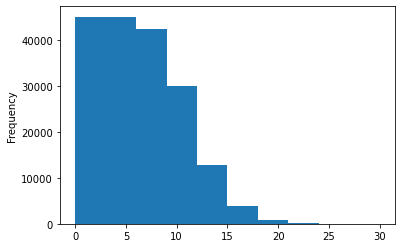

In [70]:
# checking line amount distribution
train_df.line_number.plot.hist()

In [71]:
# one-hot encoding the line quantity data in order to make positional embeddings
## to get an array we need to pass '.to_numpy()'
train_ln_ohe = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_ln_ohe = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_ln_ohe = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

In [72]:
# checking ohe data
train_ln_ohe.shape, train_ln_ohe[:10]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>)

In [73]:
# encoding the total lines
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<AxesSubplot:ylabel='Frequency'>

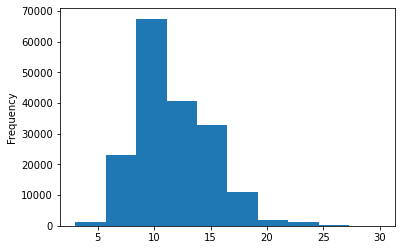

In [74]:
# distribution
train_df.total_lines.plot.hist()

In [75]:
# checking until which number the data has at least 98% of data
np.percentile(train_df.total_lines, 98)

20.0

In [76]:
# ohe the total lines to serve as an input to the model
train_tl_ohe = tf.one_hot(train_df.total_lines.to_numpy(), depth=20)
val_tl_ohe = tf.one_hot(val_df.total_lines.to_numpy(), depth=20)
test_tl_ohe = tf.one_hot(test_df.total_lines.to_numpy(), depth=20)

train_tl_ohe[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     